In [ ]:
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.metrics import Recall

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, \
cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, classification_report, recall_score
from sklearn.preprocessing import LabelBinarizer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from src.functions import load_OU_data, CourseScaler, pass_f1, score_grid, \
plot_confusion, make_gridpipe, f1
import warnings

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

In [ ]:
# df = load_OU_data(prediction_window=100)
# df.drop(columns = ['id_student','code_presentation','region','highest_education', \
#                    'imd_band','gender','age_band','disability','studied_credits',
#                    'module_presentation_length','date_registration'], inplace = True)
# if 'date_unregistration' in df.columns:
#     df.drop(columns = ['date_unregistration'], inplace = True)


X = df.drop(columns = ['final_result'])
y = df['final_result']



y3 = np.array(['Pass' if label == 'Distinction' else label for label in y])

binarizer = LabelBinarizer()

y_hot = binarizer.fit_transform(y3)
print(binarizer.classes_)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, random_state=111, test_size=0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=0.2)

In [102]:
y_train.shape

(18094, 3)

In [ ]:
def dense_model1():
    model = keras.models.Sequential()
    model.add(Dense(5, input_dim = 6, activation = 'relu'))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=[f1])
    return model
model = KerasClassifier(build_fn=dense_model1,
                        epochs=50,
                        batch_size=100,
                        verbose=1
                        )

densepipe = Pipeline(steps = [('scaler', CourseScaler()),
                    ('smoter', SMOTE(random_state=111)),
                    ('model', model)])

scores = cross_val_score(densepipe, X_t, y_t, cv=cv, scoring = make_scorer(pass_f1))
print('F1 for "Pass":')
y_pred = cross_val_predict(densepipe, X_val, y_val, cv=cv)
y_pred = np.argmax(y_pred,axis=1)
print(np.mean(scores))
plot_confusion(y_val, y_pred, labels=labels)
print(classification_report(y_val,y_pred))

Epoch 1/10
280/280 [==============================] - 1s 3ms/step - loss: 1.0989 - recall_18: 0.0000e+00 - val_loss: 1.0585 - val_recall_18: 0.0000e+00
Epoch 2/10
280/280 [==============================] - 1s 3ms/step - loss: 1.0174 - recall_18: 0.0000e+00 - val_loss: 0.9991 - val_recall_18: 0.0000e+00
Epoch 3/10
280/280 [==============================] - 1s 3ms/step - loss: 1.0029 - recall_18: 0.0745 - val_loss: 0.9738 - val_recall_18: 0.4572
Epoch 4/10
280/280 [==============================] - 1s 3ms/step - loss: 0.9970 - recall_18: 0.5063 - val_loss: 0.9735 - val_recall_18: 0.5037
Epoch 5/10
280/280 [==============================] - 1s 3ms/step - loss: 0.9932 - recall_18: 0.5325 - val_loss: 0.9619 - val_recall_18: 0.5183
Epoch 6/10
280/280 [==============================] - 1s 3ms/step - loss: 0.9897 - recall_18: 0.5386 - val_loss: 0.9441 - val_recall_18: 0.5217
Epoch 7/10
280/280 [==============================] - 1s 3ms/step - loss: 0.9868 - recall_18: 0.5311 - val_loss: 0.9542 

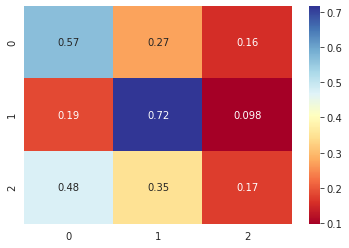

In [112]:

def dense_model2():
    model = keras.models.Sequential()
    model.add(Dense(5, input_dim = 6, activation = 'relu'))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=[Recall(class_id=1)])
    return model

cs = CourseScaler()
cs.fit(X_t)
X_val_cs = cs.transform(X_val)

model = KerasClassifier(build_fn=dense_model2,
                        epochs=10,
                        batch_size=100,
                        verbose=1,
                        validation_data = (X_val_cs,y_val)
                        )

densepipe = Pipeline(steps = [('scaler', CourseScaler()),
                    ('smoter', SMOTE(random_state=111)),
                    ('model', model)])

densepipe.fit(X_t,y_t)
y_pred = densepipe.predict(X_val)
y_true = np.argmax(y_val, axis=1)
plot_confusion(y_true, y_pred, labels=None)
print(classification_report(y_true,y_pred))

In [117]:

def dense_model3():
    model = keras.models.Sequential()
    model.add(Dense(5, input_dim = 6, activation = 'relu',
                    kernel_regularizer = 'elasticnet'))
    model.add(Dropout(rate=.2))
    model.add(Dense(5, input_dim = 6, activation = 'relu',
                    kernel_regularizer = 'elasticnet'))
    model.add(Dropout(rate=.2))
    model.add(Dense(5, input_dim = 6, activation = 'relu',
                    kernel_regularizer = 'elasticnet'))

    model.add(Dropout(rate=.2))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=[Recall(class_id=1)])
    return model

cs = CourseScaler()
cs.fit(X_t)
X_val_cs = cs.transform(X_val)

model = KerasClassifier(build_fn=dense_model2,
                        epochs=100,
                        batch_size=100,
                        verbose=1,
                        validation_data = (X_val_cs,y_val)
                        )

densepipe = Pipeline(steps = [('scaler', CourseScaler()),
                    ('smoter', SMOTE(random_state=111)),
                    ('model', model)])

densepipe.fit(X_t,y_t)


Epoch 1/100
280/280 [==============================] - 1s 3ms/step - loss: 1.1191 - recall_21: 0.0540 - val_loss: 1.0177 - val_recall_21: 0.1410
Epoch 2/100
280/280 [==============================] - 1s 3ms/step - loss: 1.0341 - recall_21: 0.2202 - val_loss: 0.9976 - val_recall_21: 0.2647
Epoch 3/100
280/280 [==============================] - 1s 3ms/step - loss: 1.0061 - recall_21: 0.3176 - val_loss: 0.9729 - val_recall_21: 0.3743
Epoch 4/100
280/280 [==============================] - 1s 3ms/step - loss: 0.9923 - recall_21: 0.4045 - val_loss: 0.9463 - val_recall_21: 0.4465
Epoch 5/100
280/280 [==============================] - 1s 3ms/step - loss: 0.9853 - recall_21: 0.4669 - val_loss: 0.9469 - val_recall_21: 0.4645
Epoch 6/100
280/280 [==============================] - 1s 3ms/step - loss: 0.9807 - recall_21: 0.4938 - val_loss: 0.9386 - val_recall_21: 0.4951
Epoch 7/100
280/280 [==============================] - 1s 3ms/step - loss: 0.9776 - recall_21: 0.5140 - val_loss: 0.9359 - val_rec

Pipeline(memory=None,
         steps=[('scaler', CourseScaler(drop_course=True)),
                ('smoter',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=111, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4acee125c0>)],
         verbose=False)

Recall for "Pass":
0.660077352814783
              precision    recall  f1-score   support

           0       0.48      0.47      0.48       897
           1       0.83      0.66      0.74      2327
           2       0.16      0.35      0.22       395

    accuracy                           0.58      3619
   macro avg       0.49      0.49      0.48      3619
weighted avg       0.67      0.58      0.61      3619



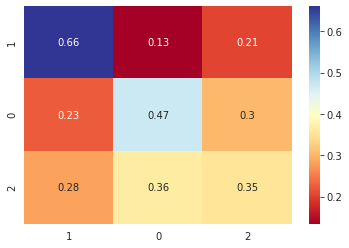

In [122]:
y_pred = densepipe.predict(X_val, verbose = 0)

y_true = np.argmax(y_val, axis=1)

print('Recall for "Pass":')
print(recall_score(y_true,y_pred, average=None)[1])
plot_confusion(y_true, y_pred, labels=[1,0,2])
print(classification_report(y_true,y_pred))

In [107]:
y_t.shape

(14475, 3)

In [108]:
densepipe.predict(X_val).shape

37/37 [==============================] - 0s 866us/step


(3619,)